In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution,  calculate_gaap_flux
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm
import cv2

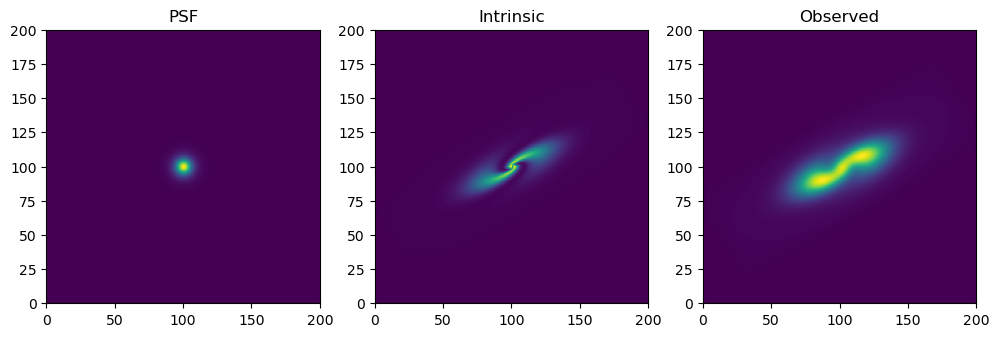

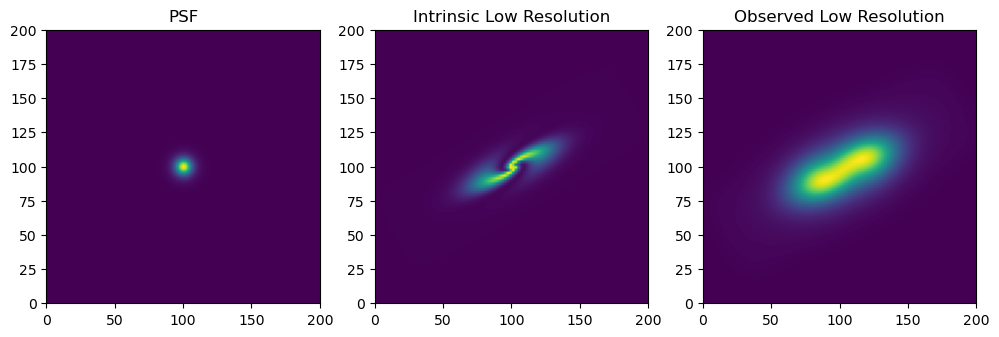

In [4]:
width = 200
height = 200

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)
image_intrinsic_low_res = cv2.resize(image_intrinsic, (width//2, height//2), interpolation=cv2.INTER_AREA)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")
image_low_res = fftconvolve(image_intrinsic_low_res, image_psf, mode="same")
# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic_low_res, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic Low Resolution")
axs[2].imshow(image_low_res, extent=(0, width, 0, height))
axs[2].set_title("Observed Low Resolution")
plt.show()

In [16]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
true_F_low_res = np.sum(weight_low_res*image_intrinsic_low_res)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}, {true_F_low_res:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, _ = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
measured_F_low_res, _ = calculate_gaap_flux(image_low_res, image_psf, weight_low_res, [(height / 4, width / 4)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}, {measured_F_low_res[0]:.6}')

The aperture flux measured using the intrinsic image and weight function : 0.251602, 0.251380
The aperture flux using the observed image and rescaled weight function : 0.251837, 0.262638
